In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from skimage.external.tifffile import imread
from skimage import io
import os
from os.path import join as oj


auxilin_dir = '/scratch/users/vision/data/abc_data/auxilin_data'
cell_name = 'Cell1_1s'
data_dir = oj(auxilin_dir, 'A7D2', cell_name) # 'A7D2', 'EGFB-GAK-F6'


fname1 = os.listdir(oj(data_dir, 'TagRFP'))[0]
fname2 = os.listdir(oj(data_dir, 'EGFP'))[0]
X = imread(oj(data_dir, 'TagRFP', fname1)) # X = RFP(clathrin) (num_images x H x W)
Y = imread(oj(data_dir, 'EGFP', fname2)) # Y = EGFP (auxilin) (num_image x H x W)

# look at data

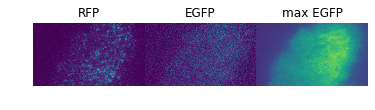

In [35]:
R, C = 1, 3
plt.figure(figsize=(C*2, R*2))

plt.subplot(R, C, 1)
plt.title('RFP')
plt.imshow(X[0])

plt.subplot(R, C, 2)
plt.title('EGFP')
plt.imshow(Y[0])

plt.subplot(R, C, 3)
plt.title('max EGFP')
plt.imshow(Y.sum(axis=0))
plt.subplots_adjust(hspace=0.1, wspace=0)

for i in range(1, 4):
    plt.subplot(R, C, i)
    plt.axis('off')

# extract single series as feature

In [53]:
X_feat = X.transpose() # W x H x num_images
X_feat = X_feat.reshape(X_feat.shape[0] * X_feat.shape[1], -1) # num_pixels x num_images
y_max = np.expand_dims(Y.sum(axis=0).flatten(), 1) # num_pixels x 1
print('shapes', X_feat.shape, Y_max.shape)

shapes (114750, 300) (114750, 1)


In [41]:
X_feat.shape

(114750, 300)

In [73]:
# m.fit(X_feat, Y_max)
X_train, X_test, Y_train, Y_test = train_test_split(X_feat, y_max, test_size=0.33, random_state=42)
# results = cross_validate(m, X_feat, y_max, cv=2, return_train_score=True, return_estimator=True)

# predict reg

In [84]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split

In [72]:
# m = LinearRegression()
m = MLPRegressor()

In [74]:
m.fit(X_train, Y_train)

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [75]:
m.score(X_test, Y_test)

-2.6811085256086042

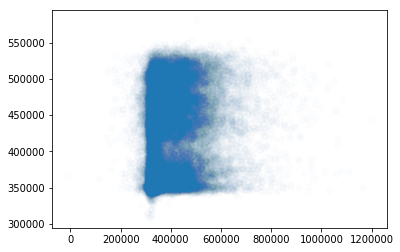

In [76]:
plt.plot(m.predict(X_test), Y_test, 'o', alpha=0.01)
plt.show()

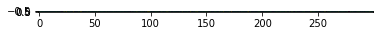

In [70]:
plt.imshow(m.coef_)

## predict logistic

In [78]:
thresh = np.percentile(Y_max, 70)

In [83]:
Y_thresh_train = 1 * (Y_train > thresh)
Y_thresh_test = 1 * (Y_test > thresh)

In [85]:
m = LogisticRegression()

In [86]:
m.fit(X_train, Y_thresh_train)

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
m.score(X_test, Y_thresh_test)

0.7006971585507552

(array([3.500e+01, 2.130e+02, 8.940e+02, 2.804e+03, 5.608e+03, 1.707e+03,
        5.900e+01, 9.000e+00, 4.000e+00, 1.000e+00]),
 array([0.05071709, 0.11467591, 0.17863474, 0.24259356, 0.30655239,
        0.37051122, 0.43447004, 0.49842887, 0.56238769, 0.62634652,
        0.69030534]),
 <a list of 10 Patch objects>)

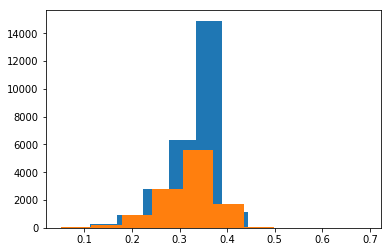

In [101]:
preds = m.predict_proba(X_test)[:, 1:2]
plt.hist(preds[Y_thresh_test==0])
plt.hist(preds[Y_thresh_test==1])
# plt.plot(, Y_thresh_test, 'o', alpha=0.5)